In [1]:
%matplotlib inline

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import LabelEncoder

Let's read the first dataset that we have:

In [3]:
combined_df = pd.read_csv("data/property_prices_combined.csv")

And check it:

In [4]:
combined_df

,Район,Цена,Цена / кв.м.,Валута,Тип Апартамент,Дата
0,Банишора,134653.98,1987.51,EUR,Двустаен апартамент,2024-07-28
1,Банкя (гр.),131843.00,1890.84,EUR,Двустаен апартамент,2024-07-28
2,Белите Брези,249900.00,2108.86,EUR,Двустаен апартамент,2024-07-28
3,Бенковски,115863.50,1782.52,EUR,Двустаен апартамент,2024-07-28
4,Борово,135594.22,2148.50,EUR,Двустаен апартамент,2024-07-28
...,...,...,...,...,...,...
2768,Стрелбище,175333.00,1075.67,EUR,Многостаен апартамемент,2021-07-28
2769,Студентски Град,222600.00,718.84,EUR,Многостаен апартамемент,2021-07-28
2770,Хаджи Димитър,205000.00,1045.92,EUR,Многостаен апартамемент,2021-07-28
2771,Хиподрума,330000.00,2357.14,EUR,Многостаен апартамемент,2021-07-28


Let's normalize the titles like convert the column names from Bulgarian to English:

In [5]:
combined_df = combined_df.rename(columns={
    'Район': 'region',
    'Цена': 'price',
    'Цена / кв.м.': 'price_per_sqm',
    'Валута': 'currency',
    'Тип Апартамент': 'apartment_type',
    'Дата': 'date'
})


combined_df.head()

,region,price,price_per_sqm,currency,apartment_type,date
0,Банишора,134653.98,1987.51,EUR,Двустаен апартамент,2024-07-28
1,Банкя (гр.),131843.00,1890.84,EUR,Двустаен апартамент,2024-07-28
2,Белите Брези,249900.00,2108.86,EUR,Двустаен апартамент,2024-07-28
3,Бенковски,115863.50,1782.52,EUR,Двустаен апартамент,2024-07-28
4,Борово,135594.22,2148.50,EUR,Двустаен апартамент,2024-07-28


#### Let's take a closer look at the dataset.

In [6]:
combined_df.shape

(2773, 6)

It has 2773 observations and 6 features.

In [7]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,2773.0,231937.814468,255154.727056,6500.0,103565.00,156238.61,255161.11,3000000.0
price_per_sqm,2773.0,1719.033722,635.308852,17.4,1335.48,1634.61,2000.00,8200.0


In [8]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2773 entries, 0 to 2772
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   region          2773 non-null   object 
 1   price           2773 non-null   float64
 2   price_per_sqm   2773 non-null   float64
 3   currency        2773 non-null   object 
 4   apartment_type  2773 non-null   object 
 5   date            2773 non-null   object 
dtypes: float64(2), object(4)
memory usage: 130.1+ KB


In [9]:
combined_df.dtypes

region             object
price             float64
price_per_sqm     float64
currency           object
apartment_type     object
date               object
dtype: object

Let's convert the "date" column in the correct data type:

In [10]:
combined_df["date"] = pd.to_datetime(combined_df["date"])

Check the converted format:

In [11]:
combined_df["date"]

0      2024-07-28
1      2024-07-28
2      2024-07-28
3      2024-07-28
4      2024-07-28
          ...    
2768   2021-07-28
2769   2021-07-28
2770   2021-07-28
2771   2021-07-28
2772   2021-07-28
Name: date, Length: 2773, dtype: datetime64[ns]

Check for NaN values:

In [12]:
combined_df.isna().sum()

region            0
price             0
price_per_sqm     0
currency          0
apartment_type    0
date              0
dtype: int64

We don't have null values in this dataset.

### Let's plot the prices over time for each apartment type:

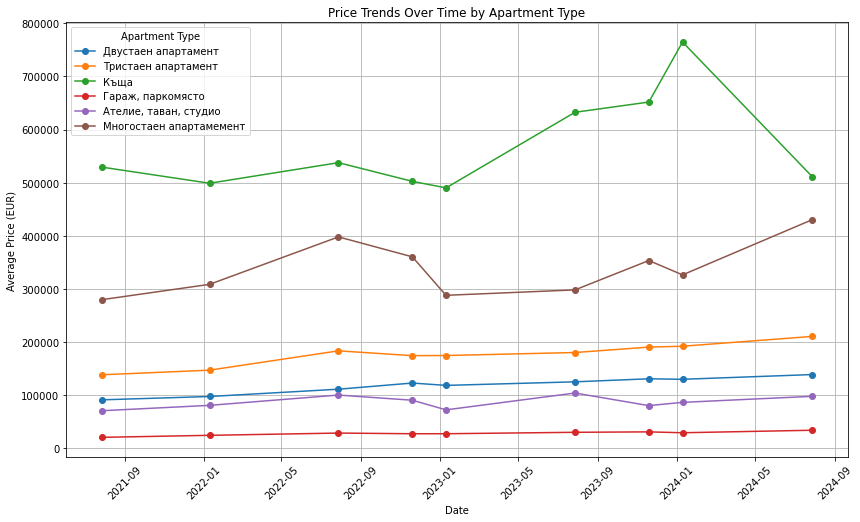

In [13]:
apartment_types = combined_df["apartment_type"].unique()

plt.figure(figsize=(14, 8))

for apartment_type in apartment_types:
    # Filter the DataFrame by apartment type
    filtered_df = combined_df[combined_df["apartment_type"] == apartment_type]
    
    # Group by date and calculate the mean price for each date
    price_over_time = filtered_df.groupby('date')['price'].median()
    
    # Plot the line for this apartment type
    plt.plot(price_over_time.index, price_over_time.values, marker='o', label=apartment_type)

plt.title('Price Trends Over Time by Apartment Type')
plt.xlabel('Date')
plt.ylabel('Average Price (EUR)')
plt.xticks(rotation=45)
plt.legend(title='Apartment Type')
plt.grid(True)
plt.show()

Let's see how many __unique Ragions__ we have:

In [14]:
len(combined_df['region'].unique())

102

And which they are:

In [15]:
combined_df['region'].unique()

array(['Банишора', 'Банкя (гр.)', 'Белите Брези', 'Бенковски', 'Борово',
       'Бояна', 'Бъкстон', 'Витоша', 'Гевгелийски', 'Гео Милев',
       'Горна Баня', 'Гоце Делчев', 'Дианабад', 'Драгалевци', 'Дружба',
       'Дружба 1', 'Дружба 2', 'Дървеница', 'Западен Парк',
       'Захарна Фабрика', 'Зона Б18', 'Зона Б19', 'Зона Б5', 'Иван Вазов',
       'Изгрев', 'Изток', 'Илинден', 'Княжево', 'Красна Поляна',
       'Красно Село', 'Кръстова Вада', 'Лагера', 'Левски', 'Левски В',
       'Левски Г', 'Лозенец', 'Люлин 1', 'Люлин 10', 'Люлин 2', 'Люлин 3',
       'Люлин 4', 'Люлин 5', 'Люлин 6', 'Люлин 7', 'Люлин 8', 'Люлин 9',
       'Люлин Център', 'м-т Гърдова глава', 'Малинова Долина',
       'Малинова долина в.з.', 'Манастирски ливади Запад',
       'Манастирски ливади Изток', 'Младост 1', 'Младост 1а', 'Младост 2',
       'Младост 3', 'Младост 4', 'Мотописта', 'Мусагеница', 'Надежда 1',
       'Надежда 2', 'Надежда 3', 'Надежда 4', 'Обеля', 'Обеля 1',
       'Обеля 2', 'Оборище', 'Овча 

In [16]:
combined_df.columns

Index(['region', 'price', 'price_per_sqm', 'currency', 'apartment_type',
       'date'],
      dtype='object')

__What are the mean prices by apartment type and date?__

In [17]:
mean_prices = combined_df.groupby(['apartment_type', 'date'])['price'].mean()

print(mean_prices)

apartment_type           date      
Ателие, таван, студио    2021-07-28     77116.214286
                         2022-01-10     94700.741111
                         2022-07-28    105442.089231
                         2022-11-19    109510.400000
                         2023-01-10    110105.194444
                         2023-07-28    125257.334000
                         2023-11-19    111184.527500
                         2024-01-10    104707.250000
                         2024-07-28    111905.708125
Гараж, паркомясто        2021-07-28     22905.646875
                         2022-01-10     24480.638750
                         2022-07-28     28337.755385
                         2022-11-19     27116.979375
                         2023-01-10     26724.520303
                         2023-07-28     31258.320789
                         2023-11-19     33171.380857
                         2024-01-10     30898.458438
                         2024-07-28     34238.918636
Двустаен а

__What are the median prices by apartment type and date?__

In [18]:
median_prices = combined_df.groupby(['apartment_type', 'date'])['price'].median()
print(median_prices)

apartment_type           date      
Ателие, таван, студио    2021-07-28     69866.500
                         2022-01-10     79990.000
                         2022-07-28     99400.000
                         2022-11-19     89664.500
                         2023-01-10     71500.000
                         2023-07-28    103250.000
                         2023-11-19     79500.000
                         2024-01-10     85638.750
                         2024-07-28     97030.000
Гараж, паркомясто        2021-07-28     19675.000
                         2022-01-10     23500.000
                         2022-07-28     27750.000
                         2022-11-19     26475.000
                         2023-01-10     26500.000
                         2023-07-28     29200.000
                         2023-11-19     30000.000
                         2024-01-10     28350.000
                         2024-07-28     33083.335
Двустаен апартамент      2021-07-28     90382.700
              

In [19]:
# # Average Price per Square Meter Over Time for Each Apartment Type
# avg_price_per_sqm = combined_df.groupby(['date', 'apartment_type'])['price_per_sqm'].mean().unstack()

# avg_price_per_sqm.plot(figsize=(12, 8))
# plt.title('Average Price per Square Meter Over Time')
# plt.xlabel('Date')
# plt.ylabel('Price per Square Meter (EUR)')
# plt.show()


__What are the most expensive regions for each apartment type?__

In [20]:
# Group by 'apartment_type' and 'region' and calculate the mean price
grouped = combined_df.groupby(['apartment_type', 'region', 'date'])['price'].mean().reset_index()

# Sort within each apartment type to find the most and least expensive regions
most_expensive = grouped.groupby('apartment_type').apply(lambda x: x.nlargest(1, 'price')).reset_index(drop=True)

# Display the results
print("Most Expensive Regions for Each Apartment Type:")
print(most_expensive)

Most Expensive Regions for Each Apartment Type:
            apartment_type                region       date      price
0    Ателие, таван, студио             Младост 3 2023-07-28   295560.0
1        Гараж, паркомясто               Оборище 2023-07-28    92750.0
2      Двустаен апартамент               Люлин 4 2022-01-10   492000.0
3                     Къща       Студентски Град 2023-07-28  3000000.0
4  Многостаен апартамемент            Иван Вазов 2023-01-10  2000000.0
5      Тристаен апартамент  Малинова долина в.з. 2023-01-10   591181.0


__What are the least expensive regions for each apartment type?__

In [21]:
# Sort within each apartment type to find the most and least expensive regions
least_expensive = grouped.groupby('apartment_type').apply(lambda x: x.nsmallest(1, 'price')).reset_index(drop=True)

print("\nLeast Expensive Regions for Each Apartment Type:")
print(least_expensive)


Least Expensive Regions for Each Apartment Type:
            apartment_type          region       date    price
0    Ателие, таван, студио         Люлин 4 2021-07-28  15000.0
1        Гараж, паркомясто          Редута 2022-07-28   6500.0
2      Двустаен апартамент  Фондови Жилища 2021-07-28  38000.0
3                     Къща    Западен Парк 2023-07-28  97500.0
4  Многостаен апартамемент         Люлин 6 2022-01-10  55100.0
5      Тристаен апартамент         Люлин 4 2021-07-28  71000.0


__Which year had the most expensive property prices?__

In [22]:
combined_df['year'] = combined_df['date'].dt.year

# Group by 'year' and calculate the average price per year
avg_price_per_year = combined_df.groupby('year')['price'].mean()

# Find the year with the highest average price
most_expensive_year = avg_price_per_year.idxmax()
highest_avg_price = avg_price_per_year.max()

print(f"The year with the most expensive prices is {most_expensive_year} with an average price of {highest_avg_price:.2f} EUR.")

print(avg_price_per_year)

The year with the most expensive prices is 2024 with an average price of 248432.14 EUR.
year
2021    173249.537153
2022    225958.331726
2023    243816.700261
2024    248432.137592
Name: price, dtype: float64


The answear is __2024__. As we can see, prices have been increasing.

__How much the price per square meter increases each year for different types of apartments?__

In [23]:
# Group by Year and Apartment Type and calculate the mean price per square meter
avg_price_per_sqm_by_year = combined_df.groupby(['year', 'apartment_type'])['price_per_sqm'].mean().reset_index()

# Calculate the yearly increase
avg_price_per_sqm_by_year['yearly_increase'] = avg_price_per_sqm_by_year.groupby('apartment_type')['price_per_sqm'].diff()

avg_price_per_sqm_by_year

,year,apartment_type,price_per_sqm,yearly_increase
0,2021,"Ателие, таван, студио",1242.373571,NaN
1,2021,"Гараж, паркомясто",906.384375,NaN
2,2021,Двустаен апартамент,1334.757586,NaN
3,2021,Къща,1506.022143,NaN
4,2021,Многостаен апартамемент,1364.870244,NaN
5,2021,Тристаен апартамент,1281.000814,NaN
6,2022,"Ателие, таван, студио",1610.543750,368.170179
7,2022,"Гараж, паркомясто",1103.260366,196.875991
8,2022,Двустаен апартамент,1672.473745,337.716159
9,2022,Къща,1818.250917,312.228775


For $2021$, there's no $2020$ data available to subtract from. So, the calculation $2021$ price - (no data) results in $NaN$.

### Identify Outliers

In [25]:
# from scipy import stats

# combined_df['z_score'] = stats.zscore(combined_df['price_per_sqm'])
# outliers = combined_df[combined_df['z_score'].abs() > 3]
# outliers

In [26]:
# combined_df = combined_df[combined_df['z_score'].abs() <= 3].copy()

In [27]:
combined_df.shape

(2773, 7)

In [28]:
import pandas as pd

def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# List of columns to check for outliers
columns_to_check = ['price', 'price_per_sqm']

# Find outliers for each column
outliers_dict = {col: find_outliers(combined_df, col) for col in columns_to_check}
outliers_dict

# Combine all outliers into a single DataFrame
all_outliers = pd.concat(outliers_dict.values()).drop_duplicates()

# Remove outliers from the original DataFrame
combined_df = combined_df[~combined_df.index.isin(all_outliers.index)]


(2419, 7)

In [29]:
combined_df.shape

(2419, 7)

### Plot the prices over time for each apartment type with removed outliers

In [30]:
# combined_df = combined_df[(combined_df['price_per_sqm'] >= lower_bound) & (combined_df['price_per_sqm'] <= upper_bound)].copy()

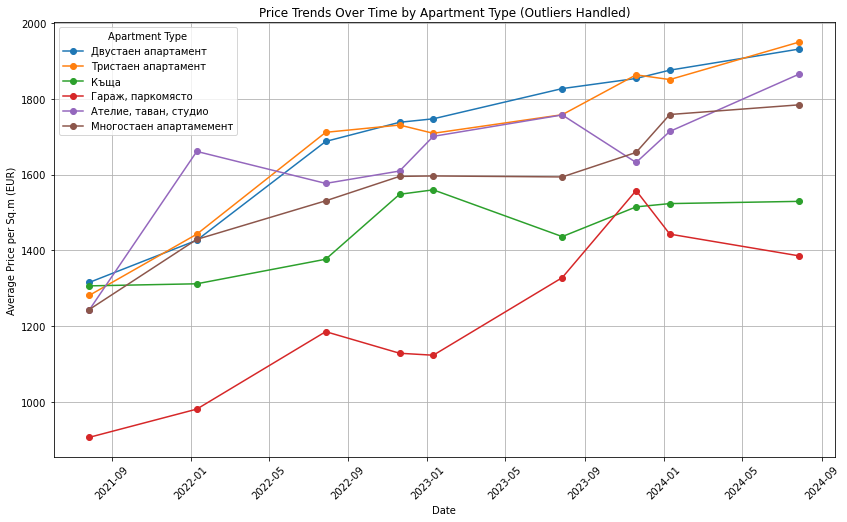

In [31]:
plt.figure(figsize=(14, 8))

for apartment_type in combined_df['apartment_type'].unique():
    filtered_df = combined_df[combined_df['apartment_type'] == apartment_type]
    price_over_time = filtered_df.groupby('date')['price_per_sqm'].mean()
    plt.plot(price_over_time.index, price_over_time.values, marker='o', label=apartment_type)

plt.title('Price Trends Over Time by Apartment Type (Outliers Handled)')
plt.xlabel('Date')
plt.ylabel('Average Price per Sq.m (EUR)')
plt.xticks(rotation=45)
plt.legend(title='Apartment Type')
plt.grid(True)
plt.show()

# Let's prepear the model and train it:

Extract date features:

In [32]:
combined_df['year'] = combined_df['date'].dt.year
combined_df['month'] = combined_df['date'].dt.month

Drop the original 'Дата' column and unnecessary columns:

In [33]:
combined_df = combined_df.drop(columns=['date', 'currency', 'price'])

In [34]:
combined_df

,region,price_per_sqm,apartment_type,year,month
0,Банишора,1987.51,Двустаен апартамент,2024,7
1,Банкя (гр.),1890.84,Двустаен апартамент,2024,7
2,Белите Брези,2108.86,Двустаен апартамент,2024,7
3,Бенковски,1782.52,Двустаен апартамент,2024,7
4,Борово,2148.50,Двустаен апартамент,2024,7
...,...,...,...,...,...
2767,Слатина,900.00,Многостаен апартамемент,2021,7
2768,Стрелбище,1075.67,Многостаен апартамемент,2021,7
2769,Студентски Град,718.84,Многостаен апартамемент,2021,7
2770,Хаджи Димитър,1045.92,Многостаен апартамемент,2021,7


Encode categorical variables:

In [35]:
label_encoder_region = LabelEncoder()
label_encoder_apartment_type = LabelEncoder()

combined_df['region'] = label_encoder_region.fit_transform(combined_df['region'])
combined_df['apartment_type'] = label_encoder_apartment_type.fit_transform(combined_df['apartment_type'])

I tested the performance of the model with OneHot encoding, but it was slightly better with LabelEncoder.

In [36]:
# label_encoder_region = OneHotEncoder(sparse=False)
# label_encoder_apartment_type = OneHotEncoder(sparse=False)

# combined_df['region'] = label_encoder_region.fit_transform(combined_df[['region']])
# combined_df['apartment_type'] = label_encoder_apartment_type.fit_transform(combined_df[['apartment_type']])

Define features and target:

In [37]:
X = combined_df.drop(columns=['price_per_sqm'], axis=1) 
y = combined_df['price_per_sqm']  # Target variable

In [38]:
X

,region,apartment_type,year,month
0,2,2,2024,7
1,3,2,2024,7
2,4,2,2024,7
3,5,2,2024,7
4,6,2,2024,7
...,...,...,...,...
2767,85,4,2021,7
2768,86,4,2021,7
2769,87,4,2021,7
2770,94,4,2021,7


Split the data into training and testing sets:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X_train

,region,apartment_type,year,month
1942,33,2,2022,7
1825,4,1,2022,11
643,85,4,2024,1
1602,85,4,2023,1
1910,88,4,2022,11
...,...,...,...,...
1906,80,4,2022,11
1284,73,4,2023,7
1322,28,2,2023,1
1509,75,3,2023,1


In [41]:
y_train

1942    1373.21
1825    1540.00
643     1555.30
1602    1420.00
1910    1451.82
         ...   
1906    1666.67
1284    1658.54
1322    2835.00
1509     956.40
1010    1244.93
Name: price_per_sqm, Length: 1935, dtype: float64

In [42]:
X_train.shape, y_test.shape

((1935, 4), (484,))

In [43]:
X_test.shape, y_train.shape

((484, 4), (1935,))

## Train the model

In [44]:
model = LinearRegression()

In [45]:
model.fit(X_train, y_train)

LinearRegression()

## Prediction results

In [46]:
y_pred = model.predict(X_test)

In [47]:
y_pred

array([1846.9281146 , 1785.89161312, 1457.81399666, 1530.11189821,
       1402.16208784, 1645.9212223 , 1915.70246448, 1344.64913804,
       1665.56563781, 1275.105888  , 1579.04343458, 1458.69548515,
       1803.97002465, 1957.39341473, 1456.38157787, 1958.77074049,
       1270.53316648, 1432.3282949 , 1374.3219101 , 1685.35335829,
       1457.37325241, 1348.28527805, 1273.45309709, 1784.78975252,
       1347.62416168, 1676.03233633, 1960.09297322, 1765.00203203,
       1850.31218859, 1258.95333027, 1776.1728179 , 1831.16361035,
       1676.77194486, 1533.36238701, 1530.55264246, 1489.7431807 ,
       1719.95040693, 1617.4604969 , 1733.10454189, 1589.33273196,
       1356.89009061, 1585.25584771, 1556.09343724, 1872.02816514,
       1664.73924235, 1773.03251516, 1846.81792854, 1720.61152329,
       1662.18156382, 1529.06513064, 1576.34387609, 1399.95836662,
       1848.85637066, 1774.9056782 , 1430.78569005, 1848.96655673,
       1429.9592946 , 1271.96558527, 1535.75478645, 1803.80474

## Make predictions

In [48]:
# Example: Predicting for 2025 with specific assumptions for features
future_data = {
    'region': label_encoder_region.transform(['Банишора', 'Белите Брези']),  # Encode regions
    'apartment_type': label_encoder_apartment_type.transform(['Двустаен апартамент', 'Тристаен апартамент']),  # Encode apartment types
    'year': [2025] * 2,  # Assuming 2 predictions for example purposes
    'month': [1, 1],  # Predicting for January 2025
}

# Convert to DataFrame
future_X = pd.DataFrame(future_data)

# Make predictions
future_predictions = model.predict(future_X)

In [49]:
# Decode the encoded labels back to their original strings
decoded_regions = label_encoder_region.inverse_transform(future_data['region'])
decoded_apartment_types = label_encoder_apartment_type.inverse_transform(future_data['apartment_type'])

# Display predictions with original labels
for i, prediction in enumerate(future_predictions):
    region_label = decoded_regions[i]
    apartment_type_label = decoded_apartment_types[i]
    print(f"Prediction for {region_label} - {apartment_type_label}: {prediction:.2f} per square meter")

Prediction for Банишора - Двустаен апартамент: 1900.82 per square meter
Prediction for Белите Брези - Тристаен апартамент: 2030.30 per square meter


## Evaluate the model

In [50]:
cdf = pd.DataFrame(model.coef_, X.columns, columns=['coefficients'])
cdf

,coefficients
region,0.055093
apartment_type,43.123369
year,185.903504
month,18.796535


In [51]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

In [52]:
print("Coefficients:", *model.coef_)
print("Intercept:", model.intercept_)
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print(f"Mean squared error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Coefficient of determination (R^2): {r2_score(y_test, y_pred):.2f}")

Coefficients: 0.05509303043203596 43.12336903800198 185.90350441973612 18.796534567893442
Intercept: -374658.93286222557
Mean Absolute Error:  332.03178375254214
Mean squared error (MSE): 182754.65
Root Mean Squared Error: 427.50
Coefficient of determination (R^2): 0.13


## Residuals

In [53]:
residuals = y_test - y_pred

In [54]:
residuals

473     -553.378115
234        8.978387
1946    -254.603997
1316      38.418102
2619    -168.902088
           ...     
2539     581.497089
843     -195.101543
337     1246.076272
2317    -627.344896
1872     405.760453
Name: price_per_sqm, Length: 484, dtype: float64

__Residuals help identify patterns in the prediction errors.__

In [55]:
combined_df.columns

Index(['region', 'price_per_sqm', 'apartment_type', 'year', 'month'], dtype='object')

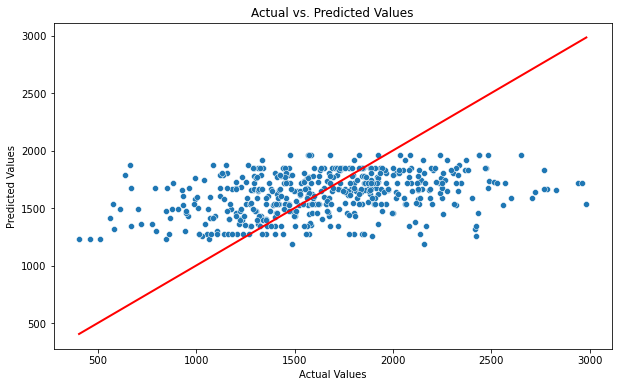

In [59]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2)
plt.show()

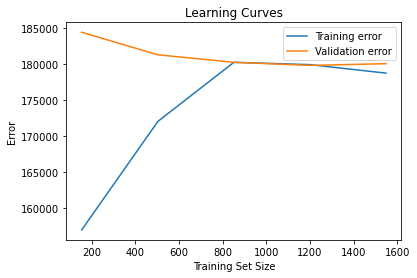

In [62]:
train_sizes, train_scores, validation_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'
)

train_errors_mean = -train_scores.mean(axis=1)
validation_errors_mean = -validation_scores.mean(axis=1)

plt.plot(train_sizes, train_errors_mean, label='Training error')
plt.plot(train_sizes, validation_errors_mean, label='Validation error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.title('Learning Curves')
plt.legend()
plt.show()

- High Bias (Underfitting): If both training and validation errors are high and similar, your model might be too simple and underfitting the data.
- High Variance (Overfitting): If the training error is much lower than the validation error, and the validation error is high, your model might be too complex and overfitting the data.

#### Cross-Validation

In [64]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-Validation Scores: {-scores.mean()} ± {scores.std()}')

Cross-Validation Scores: 180040.941957034 ± 10346.490266806832
